In [3]:
import torch 
import torch.nn as nn
from torch.optim import SGD,lr_scheduler
from torch.nn import Sequential, Linear, Embedding
from torch.utils.data import DataLoader
import torchtext




##other library
import numpy as np
import datasets
import os 
import tqdm
import collections



/home/akash/anaconda3/envs/vision/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device=('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ',device)

device:  cuda


In [5]:
seed=1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True


In [6]:
train_data,test_data=datasets.load_dataset('imdb',split=['train','test'])

In [7]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [8]:
train_data['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [9]:
train_data.features ## have two labels neg and pos

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [10]:
print(train_data[0]['text'][:100])
print(train_data[0]['label'])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w
0


In [11]:
train_data[0].keys()

dict_keys(['text', 'label'])

Tokenization

ML models trains on numerical value only. So we will convert each string to int value using tokenizer. In order to do so first we need to separate `str` to individual tokens, and laters converts them into number. 

- using,`tokenizer` we will convert strings into number of tokens first. 
- later, we will use look_up_table  to convert each tokens(in str) to int. We do this by creating a vocabulary.

In [13]:
tokenizer=torchtext.data.utils.get_tokenizer('basic_english')

In [14]:
sample_text='Hello, I am from Nepal!'

In [15]:
sample_tokenized_text=tokenizer(sample_text)
print(sample_tokenized_text)

['hello', ',', 'i', 'am', 'from', 'nepal', '!']


In [16]:
# ## sometimes the str might contain to many unnecessary tokens; so we will take max_length and define by function

# def tokenize_example(example,tokenizer,max_length):
#     tokens=tokenizer(example['text'])[:max_length]
#     return {'tokens':tokens}

# ## we return dictionary coz train_data are in the same format.  When use with map fucntion later we will see new tokens (with key) is appended in train_data format
# max_length=256

# train_data=train_data.map(tokenize_example,
#                           fn_kwargs={'tokenizer':tokenizer,
#                                      'max_length':max_length})

# test_data=test_data.map(tokenize_example,
#                           fn_kwargs={'tokenizer':tokenizer,
#                                      'max_length':max_length})

In [17]:
## sometimes the str might contain to many unnecessary tokens; so we will take max_length and define by function

def tokenize_example(example,max_length):
    tokens=tokenizer(example['text'])[:max_length]
    return {'tokens':tokens}

## we return dictionary coz train_data are in the same format.  When use with map fucntion later we will see new tokens (with key) is appended in train_data format
max_length=256

train_data=train_data.map(tokenize_example,
                          fn_kwargs={
                                     'max_length':max_length})

test_data=test_data.map(tokenize_example,
                          fn_kwargs={
                                     'max_length':max_length})

In [18]:
train_data[0]['text'][:100] ##we will convert this to tokens using the above fucntion

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w'

In [19]:
for i in train_data['tokens']:
    if len(i)<100:
        print(len(i))

92
99
57
86
64
61
56
83
83
58
86
82
69
95
95
50
99
84
71
64
68
61
93
92
67
41
73
80
75
74
28
96
47
89
16
73
95
40
79
87
49
93
74
68
56
72
95
55
57
68
89
94
76
67
54
57
94
42
46
81
44
84
85
18
91
71
99
72
37
80
94
79
68
93
65
83
42
61
67
99
57
67
60
93
71
51
63
64
93
76
87
89
61
63
90
65
65
77
96
83
86
55
46
43
96
73
68
80
99
77
66
83
70
60
62
83
63
95
77
62
70
69
83
90
86
69
96
97
44
96
53
97
97
53
79
72
92
48
86
32
80
69
51
57
97
98
63
82
68
59
66
90
24
77
79
57
74
70
68
49
97
92
75
73
47
82
74
55
98
77
88
76
91
67
98
91
59
54
87
51
79
75
85
86
79
62
67
89
91
78
89
39
71
87
88
75
68
51
82
75
72
60
77
64
39
65
84
78
46
13
75
55
95
74
60
93
89
58
55
96
88
50
32
94
98
93
57
77
75
85
52
71
86
49
84
69
96
58
72
98
66
64
59
62
70
91
55
90
94
97
74
59
65
76
79
25
83
60
55
96
55
78
77
88
57
42
86
87
69
68
64
90
98
53
43
66
92
98
42
60
71
69
45
83
83
64
95
44
94
70
55
56
81
65
57
76
78
72
63
66
73
84
38
77
56
89
99
97
57
39
63
68
76
63
98
44
37
79
66
66
83
98
49
72
91
60
54
78
38
95
57
51
86
8

In [20]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [21]:
train_data

Dataset({
    features: ['text', 'label', 'tokens'],
    num_rows: 25000
})

In [22]:
len(train_data[0]['tokens']) ### mapped from above function 

256

In [23]:
len(train_data['tokens']) ## will load will athe tokens

25000

In [24]:
train_data['tokens'][0]

['i',
 'rented',
 'i',
 'am',
 'curious-yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967',
 '.',
 'i',
 'also',
 'heard',
 'that',
 'at',
 'first',
 'it',
 'was',
 'seized',
 'by',
 'u',
 '.',
 's',
 '.',
 'customs',
 'if',
 'it',
 'ever',
 'tried',
 'to',
 'enter',
 'this',
 'country',
 ',',
 'therefore',
 'being',
 'a',
 'fan',
 'of',
 'films',
 'considered',
 'controversial',
 'i',
 'really',
 'had',
 'to',
 'see',
 'this',
 'for',
 'myself',
 '.',
 'the',
 'plot',
 'is',
 'centered',
 'around',
 'a',
 'young',
 'swedish',
 'drama',
 'student',
 'named',
 'lena',
 'who',
 'wants',
 'to',
 'learn',
 'everything',
 'she',
 'can',
 'about',
 'life',
 '.',
 'in',
 'particular',
 'she',
 'wants',
 'to',
 'focus',
 'her',
 'attentions',
 'to',
 'making',
 'some',
 'sort',
 'of',
 'documentary',
 'on',
 'what',
 'the',
 'average',
 'swede',
 'thought',


In [25]:
train_data[0]['tokens']==train_data['tokens'][0]
## however, train_data['tokens'][0] will load all dataset, and select first index. So, prefer to use train_data[0]['tokens'] to be used

True

In [26]:
train_data[0]['tokens'][:25]

['i',
 'rented',
 'i',
 'am',
 'curious-yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967',
 '.']

In [27]:
## now we will split 25% of train_data to val_data

train_valid_data=train_data.train_test_split(test_size=0.25)
train_data=train_valid_data['train']
val_data=train_valid_data['test']

In [28]:
len(train_data) ## total data

18750

## Creating a vocabulary



In [29]:
min_freq=1
special_tokens=['unk','pad'] ## vocabs which appears less than 5 times or not present will be give 'unk' tokens, and if sample have 

example_tokens=[['Hi', 'I', 'am', "Akash"],
                ['Hi', "how","am","are"],
                ['ez','sir']]

example_vocab=torchtext.vocab.build_vocab_from_iterator(
    example_tokens,
    min_freq=min_freq,
    specials=special_tokens
)

In [30]:
## see the how vocab is used
example_vocab.get_itos() ## first vocabs is filled with special tokens, later the most repeated tokens first. If same freq is same then according to alphabetical value 

['unk', 'pad', 'Hi', 'am', 'Akash', 'I', 'are', 'ez', 'how', 'sir']

In [31]:
## Check the IDX value 
print('unk idx :',example_vocab['unk'])
print('Akash: ',example_vocab['Akash'])


unk idx : 0
Akash:  4


In [32]:
## checking if the word is in vocabulary
print("Akash" in example_vocab)
print("akash" in example_vocab)


True
False


In [33]:
## What if the tokens is not in dictionary
try:
    example_vocab['akash']
except:
    print("Can't access the tokens in vocabs ") 

## so in order to return 'unk' tokens or 0 value for tokens not in dictionary we have to do thus
unk_idx=example_vocab['unk']
example_vocab.set_default_index(unk_idx)

Can't access the tokens in vocabs 


In [34]:
example_vocab['akash'] ## return 0 for unknown tokens

0

In [35]:
##list of tokens to indices
example_tokens_to_indices=example_vocab.lookup_indices(["Hi", "Nepal"])
print(example_tokens_to_indices)

[2, 0]


Creating Vocabulary on train_data

Note: We only create vocabs on train_data; Not on test data so that information is not leaked. 

In [36]:
min_freq=5
special_tokens=['unk','pad'] ## vocabs which appears less than 5 times or not present will be give 'unk' tokens, and if sample have 

vocab=torchtext.vocab.build_vocab_from_iterator(
    train_data['tokens'],
    min_freq=min_freq,
    specials=special_tokens
)

In [37]:
print('sample tokenized example: ',sample_tokenized_text)
# print('ids from tokens: ',vocab(sample_tokenized_text)) ## converted to int value

sample tokenized example:  ['hello', ',', 'i', 'am', 'from', 'nepal', '!']


In [38]:
vocab.set_default_index(0)

In [39]:
vocab['hello']

4927

In [40]:
vocab.lookup_indices(sample_tokenized_text)

[4927, 4, 12, 220, 45, 18618, 36]

In [41]:
vocab.lookup_indices(train_data[0]['tokens'])[:25]

[900,
 446,
 10,
 34,
 7,
 2,
 131,
 7,
 2,
 1503,
 113,
 167,
 2,
 2470,
 3,
 11,
 17,
 637,
 241,
 300,
 104,
 2,
 10262,
 318,
 7]

In [42]:
## we will add the indices features to train_data

def  numericialize_tokens(example,vocab):
    ids=vocab.lookup_indices(example['tokens'])
    return {'ids':ids}

train_data=train_data.map(numericialize_tokens,
                          fn_kwargs={'vocab':vocab})


val_data=val_data.map(numericialize_tokens,
                          fn_kwargs={'vocab':vocab})

test_data=test_data.map(numericialize_tokens,
                        fn_kwargs={'vocab':vocab})

Map: 100%|██████████| 25000/25000 [00:08<00:00, 2986.93 examples/s]


In [40]:
print('mapped train_data.features: ',train_data.features)

mapped train_data.features:  {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [41]:
train_data[0]['ids'][:25]

[1233,
 172,
 13340,
 15975,
 11214,
 9,
 16,
 427,
 95,
 1018,
 3671,
 10,
 14,
 197,
 4,
 5,
 1592,
 1143,
 65,
 0,
 3,
 1592,
 1143,
 65,
 400]

In [42]:
## creatomg tp pytoprch
train_data=train_data.with_format(type='torch',columns=['ids','label']) ## convert "ids" and "label" features to torch format ; Not  other
test_data=test_data.with_format(type='torch',columns=['ids','label'])
val_data=val_data.with_format(type='torch',columns=['ids','label'])

In [43]:
type(train_data[0]['ids'])

torch.Tensor

In [44]:
def get_collate_fnc(pad_index):
    
    def collate_fnc(batch):
        batch_ids=[i['ids'] for i in batch] ## You can try [i['ids'] for i train_data] train_data_len==batch
        batch_ids=torch.nn.utils.rnn.pad_sequence(batch_ids,padding_value=pad_index,batch_first=True)
        batch_label=[i['label'] for i in batch]
        batch_label=torch.stack(batch_label)
        batch={'ids':batch_ids,'label':batch_label}
        return batch
    return collate_fnc


In [45]:
## define Dataloader

def get_data_loader(dataset,batch_size,pad_index,shuffle=False):
    collate_fnc=get_collate_fnc(pad_index=pad_index)
    data_loader=DataLoader(dataset,
                           batch_size=batch_size,
                           collate_fn=collate_fnc,
                           shuffle=shuffle)
    return data_loader

In [46]:
## set shuffle ==True only for train_dataloader
batch_size=512
pad_idx=0
train_data_loader=get_data_loader(train_data,batch_size=batch_size,pad_index=pad_idx,shuffle=True)
test_data_loader=get_data_loader(test_data,batch_size=batch_size,pad_index=pad_idx)
val_data_loader=get_data_loader(val_data,batch_size=batch_size,pad_index=pad_idx)

In [47]:
for num,batch in enumerate(train_data_loader):
    if num==10:
        break

    print(batch['ids'].shape)

train_data_loader=get_data_loader(train_data,batch_size=batch_size,pad_index=pad_idx,shuffle=True)
    

torch.Size([512, 256])
torch.Size([512, 256])
torch.Size([512, 256])
torch.Size([512, 256])
torch.Size([512, 256])
torch.Size([512, 256])
torch.Size([512, 256])
torch.Size([512, 256])
torch.Size([512, 256])
torch.Size([512, 256])


In [48]:
batch['ids'].shape ## batch_size,max_length

torch.Size([512, 256])

In [49]:
### defining a Neural Bag of Words
class NBoW(nn.Module):

    def __init__(self,vocab_size,embedding_dim,output_dim):
        super(NBoW,self).__init__()
        self.embedding=nn.Embedding(num_embeddings=vocab_size,embedding_dim=embedding_dim) ## return batch_size,num_tokens,emdbedding_dim
        self.fc=nn.Linear(in_features=embedding_dim,out_features=output_dim)

    def forward(self,x):
        embedding_output=self.embedding(x) ## return batch_size,num_tokens,emdbedding_dim
        polled_output=embedding_output.mean(dim=1) ## returns batch_size,embedding_dim
        prediction=self.fc(polled_output)
        return prediction

In [50]:
## defining the training parameters 

vocab_size=len(vocab)
embedding_dim=300
output_dim=len(train_data.unique('label'))

In [51]:
##testing the model on defined model

nbow=NBoW(vocab_size,embedding_dim,output_dim).to(device=device)
ids=batch['ids'].to(device=device)
print('ids.shape :',ids.shape)

test_output=nbow(ids)
print('test_output.shape: ',test_output.shape)
print('real_label.shape')

ids.shape : torch.Size([512, 256])
test_output.shape:  torch.Size([512, 2])
real_label.shape


In [52]:
a=torch.tensor([1,2,3,4,5],dtype=torch.float32)
b=torch.tensor([1,2,3,8,9],dtype=torch.float32)


In [53]:
a.eq(b).sum()/2

tensor(1.5000)

In [54]:
## defining accuracy

def get_accuracy(prediction,label):
    batch_size,_=prediction.shape
    prediction_classes=prediction.argmax(dim=1)
    corrected_prediction=prediction_classes.eq(label).sum()
    accuracy=corrected_prediction/batch_size
    return accuracy ## return tnesor as well

In [55]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [56]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [57]:
##defining criterion
criterion=nn.CrossEntropyLoss().to(device=device)
optimizer=torch.optim.Adam(nbow.parameters())

In [58]:
save_dire="../saved_model/nbow.pt"
n_epochs=25
best_valid_loss=float("inf")

metrics=collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss,train_acc=train(train_data_loader,device=device,
                                  model=nbow,criterion=criterion,
                                  optimizer=optimizer)
    
    val_loss,val_acc=evaluate(val_data_loader,device=device,
                                  model=nbow,criterion=criterion
                        )
    
    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)
    metrics['val_loss'].append(val_loss)
    metrics['val_acc'].append(val_acc)
    if val_loss<train_loss:
       
        best_valid_loss=val_loss
        
        torch.save(nbow.state_dict(),save_dire)

    print("Epoch Num: ", epoch)
    print('Train Loss: {:.3f}   | Train Acc: {:.3f}'.format(train_loss,train_acc))
    print('Val Loss: {:.3f}   | Val Acc: {:.3f}'.format(val_loss,val_acc))




# best Validation loss

nbow.load_state_dict(torch.load(save_dire))
best_val_loss,best_val_acc=evaluate(val_data_loader,device=device,
                                  model=nbow,criterion=criterion
                                )

print('Best Val Loss: {:.3f}   | Best Val Acc: {:.3f}'.format(best_val_loss,best_val_acc))



    

evaluating...: 100%|██████████| 13/13 [00:00<00:00, 48.76it/s]


Epoch Num:  0
Train Loss: 0.688   | Train Acc: 0.561
Val Loss: 0.676   | Val Acc: 0.636


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 44.36it/s]


Epoch Num:  1
Train Loss: 0.663   | Train Acc: 0.678
Val Loss: 0.650   | Val Acc: 0.695


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 50.89it/s]


Epoch Num:  2
Train Loss: 0.633   | Train Acc: 0.706
Val Loss: 0.618   | Val Acc: 0.726


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 49.71it/s]


Epoch Num:  3
Train Loss: 0.594   | Train Acc: 0.740
Val Loss: 0.581   | Val Acc: 0.740


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 47.16it/s]


Epoch Num:  4
Train Loss: 0.551   | Train Acc: 0.770
Val Loss: 0.542   | Val Acc: 0.774


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 46.84it/s]


Epoch Num:  5
Train Loss: 0.505   | Train Acc: 0.800
Val Loss: 0.504   | Val Acc: 0.791


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 46.79it/s]


Epoch Num:  6
Train Loss: 0.462   | Train Acc: 0.823
Val Loss: 0.469   | Val Acc: 0.812


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 47.18it/s]


Epoch Num:  7
Train Loss: 0.422   | Train Acc: 0.849
Val Loss: 0.440   | Val Acc: 0.825


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 43.74it/s]


Epoch Num:  8
Train Loss: 0.387   | Train Acc: 0.865
Val Loss: 0.416   | Val Acc: 0.834


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 45.51it/s]


Epoch Num:  9
Train Loss: 0.358   | Train Acc: 0.876
Val Loss: 0.397   | Val Acc: 0.839


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 40.96it/s]


Epoch Num:  10
Train Loss: 0.332   | Train Acc: 0.888
Val Loss: 0.380   | Val Acc: 0.846


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 42.08it/s]


Epoch Num:  11
Train Loss: 0.310   | Train Acc: 0.896
Val Loss: 0.366   | Val Acc: 0.850


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 44.69it/s]


Epoch Num:  12
Train Loss: 0.291   | Train Acc: 0.903
Val Loss: 0.355   | Val Acc: 0.851


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 41.55it/s]


Epoch Num:  13
Train Loss: 0.274   | Train Acc: 0.909
Val Loss: 0.346   | Val Acc: 0.856


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 43.66it/s]


Epoch Num:  14
Train Loss: 0.259   | Train Acc: 0.916
Val Loss: 0.338   | Val Acc: 0.857


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 42.38it/s]


Epoch Num:  15
Train Loss: 0.244   | Train Acc: 0.922
Val Loss: 0.332   | Val Acc: 0.861


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 42.36it/s]


Epoch Num:  16
Train Loss: 0.234   | Train Acc: 0.925
Val Loss: 0.328   | Val Acc: 0.862


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 44.34it/s]


Epoch Num:  17
Train Loss: 0.221   | Train Acc: 0.929
Val Loss: 0.322   | Val Acc: 0.864


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 41.70it/s]


Epoch Num:  18
Train Loss: 0.210   | Train Acc: 0.936
Val Loss: 0.319   | Val Acc: 0.867


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 43.59it/s]


Epoch Num:  19
Train Loss: 0.201   | Train Acc: 0.938
Val Loss: 0.316   | Val Acc: 0.867


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 43.51it/s]


Epoch Num:  20
Train Loss: 0.191   | Train Acc: 0.942
Val Loss: 0.313   | Val Acc: 0.868


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 43.43it/s]


Epoch Num:  21
Train Loss: 0.183   | Train Acc: 0.946
Val Loss: 0.310   | Val Acc: 0.871


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 43.88it/s]


Epoch Num:  22
Train Loss: 0.175   | Train Acc: 0.947
Val Loss: 0.310   | Val Acc: 0.871


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 42.28it/s]


Epoch Num:  23
Train Loss: 0.168   | Train Acc: 0.950
Val Loss: 0.307   | Val Acc: 0.874


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 42.88it/s]


Epoch Num:  24
Train Loss: 0.160   | Train Acc: 0.953
Val Loss: 0.306   | Val Acc: 0.873


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 41.67it/s]


Best Val Loss: 0.504   | Best Val Acc: 0.791


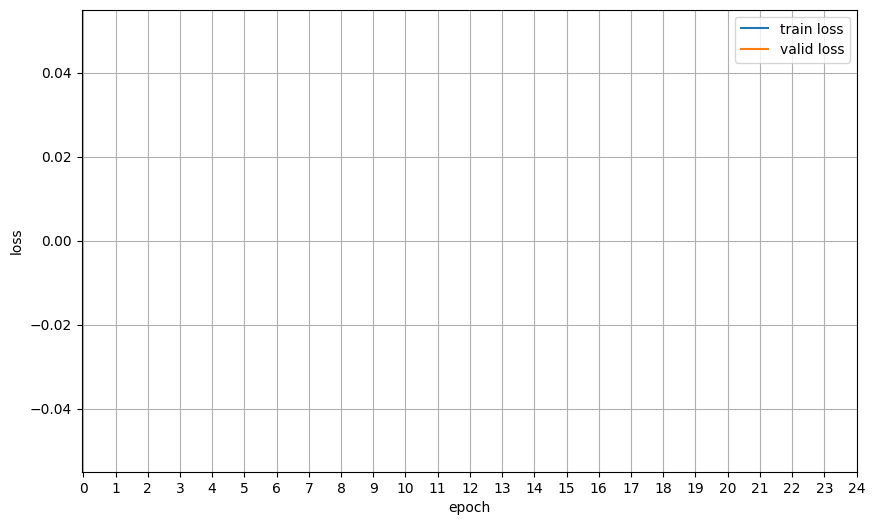

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()